In [22]:
import numpy as np
# This just ensures some comments in dataframes below display nicely
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


pd.options.display.max_colwidth = 100

In [2]:
import straxen
st = straxen.contexts.strax_workshop_dali()

In [3]:
straxen.download_test_data()

In [47]:
st.data_info('peaks')

,Field name,Data type,Comment
0,channel,int16,Channel/PMT number
1,dt,int16,Time resolution in ns
2,time,int64,Start time of the interval (ns since unix epoch)
3,length,int32,Length of the interval in samples
4,area,float32,Integral across channels in photoelectrons
5,area_per_channel,"('<i4', (248,))",Integral per channel in ADX x samples (not PE!)
6,n_hits,int16,Number of hits from which peak was constructed (currently zero if peak is split afterwards)
7,data,"('<f4', (200,))",Waveform data in PE/sample (not PE/ns!)
8,width,"('<f4', (11,))",Peak widths in ns: range of central area fraction
9,saturated_channel,"('<i2', (248,))",Check if channel is saturated


In [5]:
dsets = st.select_runs(
                       include_tags='sciencerun2_preliminary',
                       exclude_tags='?fterNG',
                       available='raw_records', 
                       run_mode='background*'
)

Checking data availability: 100%|██████████| 5/5 [00:02<00:00,  2.56it/s]


In [7]:
n_runs = 5
dsets_sample = dsets.head(n_runs)
run_ids = dsets_sample.name.values.tolist()
run_ids = ['180215_1029']

In [131]:
df = st.get_df(run_ids, 'event_info')

In [139]:
peak_data = st.get_array(run_ids, ['peaks', 'peak_basics', 'peak_classification'])

In [140]:
peak_data.dtype.names

('channel',
 'dt',
 'time',
 'length',
 'area',
 'area_per_channel',
 'n_hits',
 'data',
 'width',
 'saturated_channel',
 'n_saturated_channels',
 'endtime',
 'n_channels',
 'max_pmt',
 'max_pmt_area',
 'range_50p_area',
 'area_fraction_top',
 'type')

In [141]:
st.search_field('*width*')

width is part of peaks (provided by Peaks)
width is part of vctuifikti (provided by vctuifikti)
width is part of fzrcaycrdf (provided by fzrcaycrdf)
width is part of ntswtokysk (provided by ntswtokysk)
width is part of nauoktyxnb (provided by nauoktyxnb)


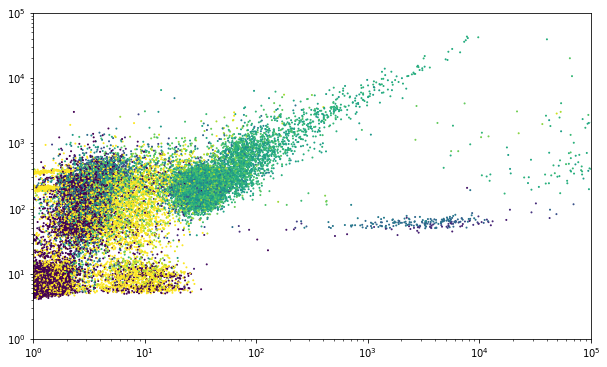

In [142]:
fig = plt.figure(figsize=(10,6))

plt.scatter(peak_data['area'], peak_data['width'][:,5], c=peak_data['area_fraction_top'], s=1)
plt.xscale('log')
plt.yscale('log')
plt.xlim([1, 1e5])
plt.ylim([1, 1e5])
plt.show()

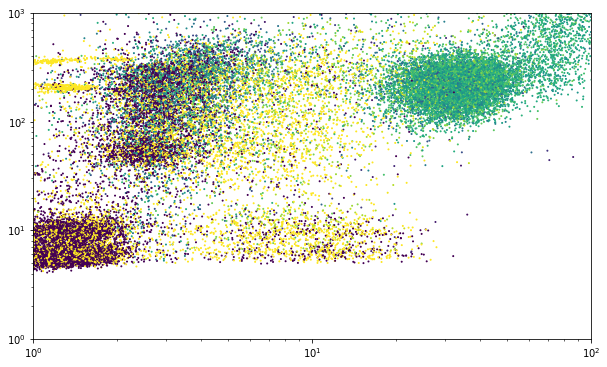

In [143]:
fig = plt.figure(figsize=(10,6))
peak_data_coin = peak_data[peak_data['n_channels']>1]
plt.scatter(peak_data['area'], peak_data['width'][:,5], c=peak_data['area_fraction_top'], s=1)
plt.xscale('log')
plt.yscale('log')
plt.xlim([1, 1e2])
plt.ylim([1, 1e3])
plt.show()

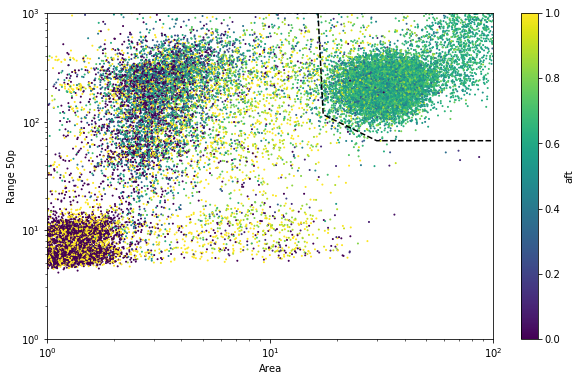

In [144]:
from scipy.interpolate import interp1d
f = interp1d([10, 20, 30, 100], [1000, 100, 100, 100])
a = 2000
b = 1000
x1 = 17
x2 = 30
def f(x):
    y = a/x
    y[x<x1] = b*np.ones(len(x[x<x1]))
    y[x>x2] = a/x2
    return y

fig = plt.figure(figsize=(10,6))
plt.scatter(peak_data_coin['area'], peak_data_coin['width'][:,5], c=peak_data_coin['area_fraction_top'], s=1)
xs = np.linspace(10, 100, 100)
plt.plot(xs, f(xs), 'k--')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1, 1e2])
plt.ylim([1, 1e3])
plt.xlabel('Area')
plt.ylabel('Range 50p')
plt.colorbar(label='aft')
plt.show()

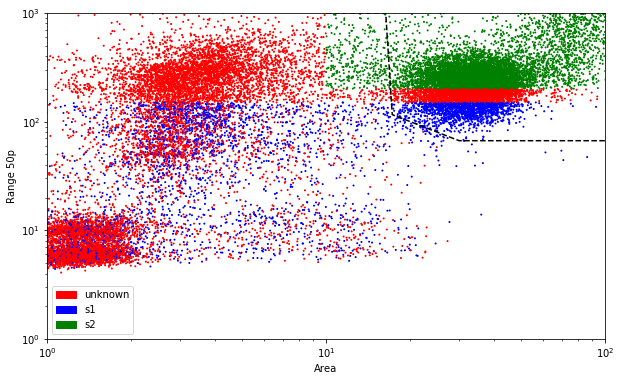

In [145]:
peak_data_coin = peak_data[(peak_data['n_channels']>1)]
import matplotlib.patches as mpatches
from scipy.interpolate import interp1d
f = interp1d([10, 20, 30, 100], [1000, 100, 100, 100])
a = 2000
b = 1000
x1 = 17
x2 = 30
def f(x):
    y = a/x
    y[x<x1] = b*np.ones(len(x[x<x1]))
    y[x>x2] = a/x2
    return y
colors = ['r','b','g']
fig = plt.figure(figsize=(10,6))
plt.scatter(peak_data_coin['area'], peak_data_coin['width'][:,5], c=[colors[i] for i in peak_data_coin['type']], s=1)
labels = ['unknown', 's1', 's2']

p0 = mpatches.Patch(color=colors[0], label='unknown')
p1 = mpatches.Patch(color=colors[1], label='s1')
p2 = mpatches.Patch(color=colors[2], label='s2')
plt.legend(handles=[p0, p1, p2], labels=['unknown', 's1', 's2'])
xs = np.linspace(10, 100, 100)
plt.plot(xs, f(xs), 'k--')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1, 1e2])
plt.ylim([1, 1e3])
plt.xlabel('Area')
plt.ylabel('Range 50p')
plt.show()

In [146]:
a = 2000
b = 1000
x1 = 17
x2 = 30
def f(x):
    y = a/x
    y[x<x1] = b*np.ones(len(x[x<x1]))
    y[x>x2] = a/x2
    return y

import strax
import numpy as np



@strax.takes_config(
    strax.Option('s1_max_width', default=150,
                 help="Maximum (IQR) width of S1s"),
    strax.Option('s1_min_n_channels', default=3,
                 help="Minimum number of PMTs that must contribute to a S1"),
    strax.Option('s2_min_area', default=10,
                 help="Minimum area (PE) for S2s"),
    strax.Option('s2_min_width', default=200,
                help="Minimum width for S2s"),
    strax.Option('s2_flat_area_threshold', default=200,
                help="Minimum width for S2s")
)
class AdvancedExpertClassification(strax.Plugin):
    """Everything is an S1!"""
    
    # Name of the data type this plugin provides
    provides = 'peak_classification'
    
    # Data types this plugin requires. Note we don't specify
    # what plugins should produce them: maybe the default PeakBasics
    # has been replaced by another AdvancedExpertBlabla plugin?
    depends_on = ('peak_basics',)
    parallel = True
    
    # Numpy datatype of the output 
    dtype = straxen.plugins.plugins.PeakClassification.dtype
    
    # Version of the plugin. Increment this if you change the algorithm.
    __version__ = '0.0.1'

    def compute(self, peaks):
        p = peaks
        r = np.zeros(len(p), dtype=self.dtype)

        is_s1 = p['n_channels'] >= self.config['s1_min_n_channels']
        is_s1 &= p['range_50p_area'] < self.config['s1_max_width']
        r['type'][is_s1] = 1

        is_s2 = p['area'] > self.config['s2_min_area']
        is_s2 &= p['range_50p_area'] > self.config['s2_min_width']
        is_s2 &= (p['range_50p_area'] > f(p['area'])) | (p['area'] > self.config['s2_flat_area_threshold'])
        r['type'][is_s2] = 2
        
        return r

In [147]:
st2 = st.new_context()
st2.register(AdvancedExpertClassification)
st2.set_config(dict(
    s2_flat_area_threshold=x2,
    s2_min_area = x1,
    s2_min_width = a/x2,
))

In [148]:
peak_data = st2.get_array(run_ids, ['peaks', 'peak_basics', 'peak_classification'])

In [149]:
np.unique(peak_data['type'])

array([0, 1, 2], dtype=int8)

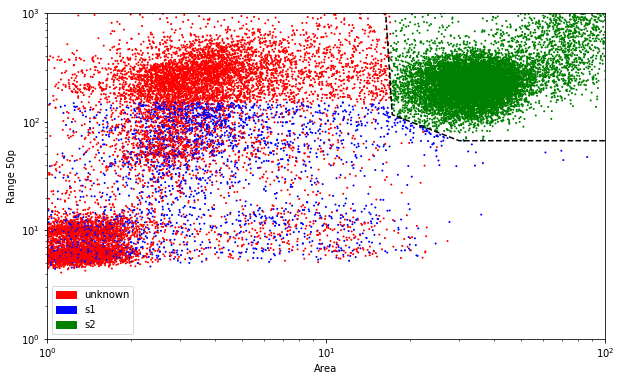

In [150]:
peak_data_coin = peak_data[(peak_data['n_channels']>1)]
import matplotlib.patches as mpatches
from scipy.interpolate import interp1d
f = interp1d([10, 20, 30, 100], [1000, 100, 100, 100])
a = 2000
b = 1000
x1 = 17
x2 = 30
def f(x):
    y = a/x
    y[x<x1] = b*np.ones(len(x[x<x1]))
    y[x>x2] = a/x2
    return y
colors = ['r','b','g']
fig = plt.figure(figsize=(10,6))
plt.scatter(peak_data_coin['area'], peak_data_coin['width'][:,5], c=[colors[i] for i in peak_data_coin['type']], s=1)
labels = ['unknown', 's1', 's2']

p0 = mpatches.Patch(color=colors[0], label='unknown')
p1 = mpatches.Patch(color=colors[1], label='s1')
p2 = mpatches.Patch(color=colors[2], label='s2')
plt.legend(handles=[p0, p1, p2], labels=['unknown', 's1', 's2'])
xs = np.linspace(10, 100, 100)
plt.plot(xs, f(xs), 'k--')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1, 1e2])
plt.ylim([1, 1e3])
plt.xlabel('Area')
plt.ylabel('Range 50p')
plt.show()

In [151]:
st.show_config('peak_classification', 's2*')

,option,default,current,applies_to,help
0,s2_min_area,10,<OMITTED>,peak_classification,Minimum area (PE) for S2s
1,s2_min_width,200,<OMITTED>,peak_classification,Minimum width for S2s
2,s2_tail_veto,True,<OMITTED>,records,Remove pulses after high-energy S2s (experimental)


In [152]:
st.data_info('peaks')
st.search_field('*hit*')

n_hits is part of peaks (provided by Peaks)
n_hits is part of vctuifikti (provided by vctuifikti)
n_hits is part of fzrcaycrdf (provided by fzrcaycrdf)
n_hits is part of ntswtokysk (provided by ntswtokysk)
n_hits is part of nauoktyxnb (provided by nauoktyxnb)


In [ ]:
import strax

class PeaksExtended(strax.Plugin):
    """Same as Peaks but add a couple pax-like things, rise time and tight_coin"""
    
    # Name of the data type this plugin provides
    provides = 'peaks'
    
    # Data types this plugin requires. Note we don't specify
    # what plugins should produce them: maybe the default PeakBasics
    # has been replaced by another AdvancedExpertBlabla plugin?
    depends_on = ('records', 'peaks')
    
    # Numpy datatype of the output 
    dtype = [
        (('Rise time of peak in ns', 'rise_time'), np.int16),
        (('Hits within tight range of mean', 'tight_coincidence'), np.int16),
    ]
    
    # Version of the plugin. Increment this if you change the algorithm.
    __version__ = '0.0.1'

        
    parallel = 'process'
    rechunk_on_save = True


    @numba.jit(nopython=True, nogil=True, cache=True)
    def compute(self, records, peaks):
        r = records
        p = peaks
        hits = strax.find_hits(r)       # TODO: Duplicate work
        hits = strax.sort_by_time(hits)
        for peak in peaks:
            peak_hits = hits[(hits['left'] > peak['time']) & (hits['right'] < (peak['time'] + (peak['length']*peak['dt'])))]
        

        strax.sum_waveform(peaks, r, self.to_pe)

        
        

        return peaks